<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 4.4MB/s 
     |████████████████████████████████| 6.8MB 11.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [10]:
# setup
import matplotlib.pyplot as plt
import pandas as pd
from numpy import mean
import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
# my libraries 
import basic_prepro as bp
import null_values as nv
import evaluation_metrics as em

In [6]:
# load data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [7]:
# basic prepocessing
# replace in class column: pos = 1; neg = 0
# replace the na and nan values with np.NaN
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [8]:
# null values
# drop the features with more than t% of null values on the train set 
# fill the remaining null values with the median of the corresponding feature with SimpleImputer(strategy = "median").
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

In [11]:
# choosing the number of neighbors k
# divide de test set into validation and test
X_test2, X_val, y_test2, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=333)

print(X_val.shape)
print(y_val.shape)
print(X_test2.shape)
print(y_test2.shape)

(5280, 162)
(5280,)
(10720, 162)
(10720,)


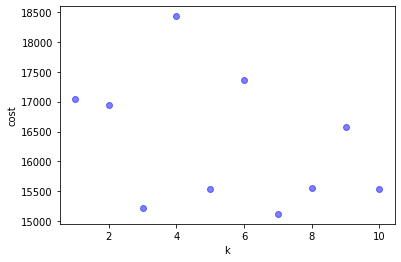

In [13]:
k_values = range(1,11)
costs = []

for k in k_values:
  # oversample
  over = SMOTE(sampling_strategy=0.6, k_neighbors=k) 
  X_res, y_res = over.fit_resample(X_train, y_train)

  # undersample
  under = RandomUnderSampler(sampling_strategy=0.8)
  X_train_up, y_train_up = under.fit_resample(X_res, y_res) 

  # define classifier
  clf = DecisionTreeClassifier()

  # traine
  clf.fit(X_train_up, y_train_up.values)
  
  # predict
  y_pred = clf.predict(X_val)

  # evaluate
  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
  c1 = 10
  c2 = 500
  cost = c1*fp + c2*fn
  costs.append(cost)

# plot
plt.scatter(k_values, costs, c="b", alpha=0.5)
plt.xlabel("k")
plt.ylabel("cost")
plt.show()

In [14]:
# Transform the training set
# oversample
k = 7
over = SMOTE(sampling_strategy=0.6, k_neighbors=k) 
X_res, y_res = over.fit_resample(X_train, y_train)
print("original")
print(y_train.value_counts())
print("after oversampling")
print(y_res.value_counts())
# undersampling
under = RandomUnderSampler(sampling_strategy=0.8)
X_train_up, y_train_up = under.fit_resample(X_res, y_res) 
print("after undersampling (final)")
print(y_train_up.value_counts())

original
0    59000
1     1000
Name: class, dtype: int64
after oversampling
0    59000
1    35400
Name: class, dtype: int64
after undersampling (final)
0    44250
1    35400
Name: class, dtype: int64


In [15]:
# check
print(X_train.shape)
print(X_train_up.shape)
print(y_train.shape)
print(y_train_up.shape)

(60000, 162)
(79650, 162)
(60000,)
(79650,)


False positives:  111
False negatives:  37
Total cost: 19610
Confusion matrix, without normalization


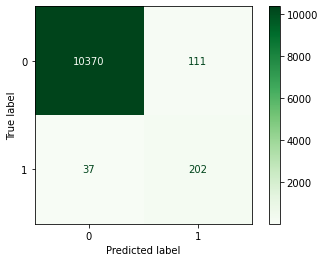

     Normalized confusion matrix


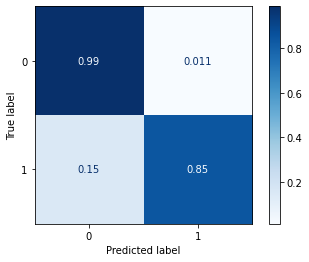

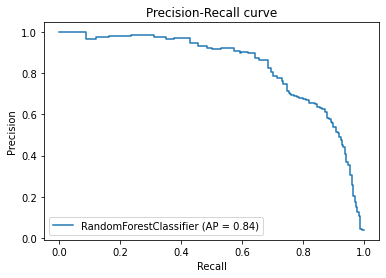

f1 score 0.732
precision:  0.645
recall 0.845


(19610, 0.7318840579710144, 0.645367412140575, 0.8451882845188284)

In [16]:
# RF
clf_RF = RandomForestClassifier(random_state=333)
# training 
clf_RF.fit(X_train_up, y_train_up.values)
# prediction
y_pred_RF = clf_RF.predict(X_test2)
# evaluation
em.evaluation_metrics(y_pred_RF, y_test2, X_test2, clf_RF, c1=10, c2=500)

False positives:  309
False negatives:  26
Total cost: 16090
Confusion matrix, without normalization


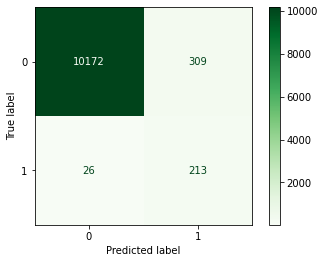

     Normalized confusion matrix


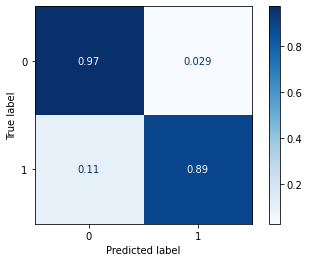

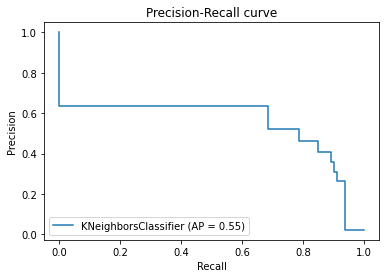

f1 score 0.56
precision:  0.408
recall 0.891


(16090, 0.5597897503285152, 0.40804597701149425, 0.891213389121339)

In [17]:
# k-NN
neigh = KNeighborsClassifier(n_neighbors=7)
# training 
neigh.fit(X_train_up, y_train_up.values)
# prediction
y_pred_neigh = neigh.predict(X_test2)
# evaluation
em. evaluation_metrics(y_pred_neigh, y_test2, X_test2, neigh, c1=10, c2=500)

False positives:  405
False negatives:  17
Total cost: 12550
Confusion matrix, without normalization


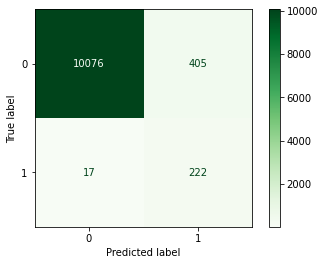

     Normalized confusion matrix


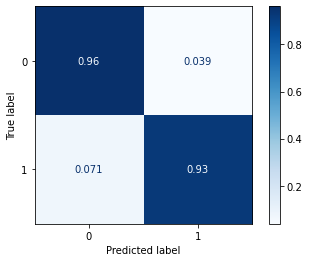

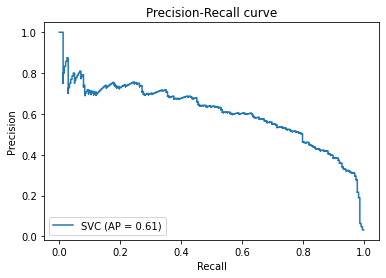

f1 score 0.513
precision:  0.354
recall 0.929


(12550, 0.5127020785219399, 0.35406698564593303, 0.9288702928870293)

In [18]:
# SVM
clf_SVM = svm.SVC()
# training 
clf_SVM.fit(X_train_up, y_train_up.values)
# prediction
y_pred_SVM = clf_SVM.predict(X_test2)
# evaluation
em. evaluation_metrics(y_pred_SVM, y_test2, X_test2, clf_SVM, c1=10, c2=500)